In [1]:
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bart_playground import *
import bartz

In [2]:
proposal_probs = {"grow" : 0.5,
                  "prune" : 0.5}
generator = DataGenerator(n_samples=360, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
np.set_printoptions(suppress=True)
print(y_train[:12])

[ 0.50114513  0.62873311  0.53828857  0.41549547  0.00699196  0.31192016
  0.0558549   0.4105654   0.478931   -0.12503155  0.06700792  0.30414086]


In [3]:
bart_full = DefaultBART(ndpost=200, nskip=200, n_trees=100, proposal_probs=proposal_probs, random_state=42)
bart_full.fit(X, y)

Iterations: 100%|██████████| 400/400 [00:03<00:00, 115.45it/s]


In [4]:
bart = DefaultBART(ndpost=200, nskip=200, n_trees=100, proposal_probs=proposal_probs, random_state=42)
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 400/400 [00:02<00:00, 151.29it/s]


In [5]:
print(mean_squared_error(y_test, bart.predict(X_test)))
print(mean_squared_error(y_test, bart_full.predict(X_test)))

0.020601295064327087
0.013234634382606436


In [6]:
from tqdm import tqdm

mse_arr = []
mse_arr.append(mean_squared_error(y_test, bart.predict(X_test)))
test_n = X_test.shape[0]
for i in tqdm(range(test_n)):
    # use i:(i+1) to avoid dimensional reduction
    bart.update_fit(X_test[i:(i+1), :], y_test[i:(i+1)], add_ndpost=2, quietly=True)
    mse_arr.append(mean_squared_error(y_test, bart.predict(X_test)))

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [00:01<00:00, 54.75it/s]


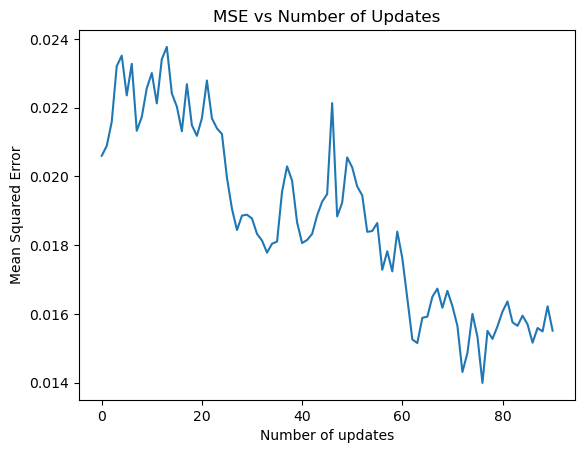

In [7]:
import matplotlib.pyplot as plt
plt.plot(mse_arr)
plt.xlabel("Number of updates")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs Number of Updates")
plt.show()

In [5]:
arrays = [tree.vars for tree in bart.trace[-1].trees]
counts = np.array([np.count_nonzero(arr >= 0) for arr in arrays])
print(counts)
deep_trees = np.array([count >= 3 for count in counts])
print(np.where(deep_trees))

[1 1 3 1 3 2 3 2 0 1 1 2 1 1 3 2 1 4 1 3 0 2 1 1 2 1 2 1 1 2 1 3 1 4 1 1 2
 3 1 3 1 2 1 3 1 2 1 1 1 1 2 3 3 1 1 0 2 2 1 1 1 1 2 5 1 3 3 1 0 1 1 2 1 1
 1 4 0 3 0 1 2 4 2 1 2 1 1 2 2 2 2 1 1 1 2 2 1 2 2 2]
(array([ 2,  4,  6, 14, 17, 19, 31, 33, 37, 39, 43, 51, 52, 63, 65, 66, 75,
       77, 81]),)


In [6]:
print(bart.trace[-1].global_params)

{'eps_sigma2': array([0.00609132])}


In [7]:
tree_sp : Tree = bart.trace[-1].trees[72]

print(tree_sp)
print(tree_sp.vars)
print(tree_sp.leaf_vals)

X_0 <= 0.434105724 (split, n = 360)
	Val: -0.002246719 (leaf, n = 157)
	Val: 0.038378350 (leaf, n = 203)
[ 0 -1 -1 -2 -2 -2 -2 -2]
[        nan -0.00224672  0.03837835         nan         nan         nan
         nan         nan]


In [8]:
rf = RandomForestRegressor(random_state=42)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=100, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-07-06 08:19:13,871:jax._src.xla_bridge:867: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Iteration 100/300 P_grow=0.58 P_prune=0.42 A_grow=0.41 A_prune=0.33 (burnin)
Iteration 200/300 P_grow=0.52 P_prune=0.48 A_grow=0.35 A_prune=0.31
Iteration 300/300 P_grow=0.53 P_prune=0.47 A_grow=0.26 A_prune=0.28


In [9]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.020800545025961018,
 'rf': 0.022721420713122355,
 'lr': 0.04590326679925266,
 'btz': 0.02072978001474411}

In [10]:
print(bart.sampler.trace[-1].evaluate(X_train)[:12])
print(bart.preprocessor.transform_y(y_train)[:12])

[ 0.37678917  0.25270448  0.40240953  0.34834934 -0.00580348  0.35338093
  0.04660577  0.26553896  0.36365574  0.11581209 -0.05939649  0.33455346]
[ 0.3528354   0.44447932  0.37951478  0.29131493 -0.00210506  0.21691883
  0.03299222  0.28777376  0.3368794  -0.09693494  0.04100322  0.21133111]


In [11]:
if all([(bart.trace[-1].trees[i].evaluate()[range(X_train.shape[0]), ] == bart.trace[-1].trees[i].evaluate(X_train)).all()
            for i in range(100)]):
    print("True")
else:
    print("False")

True
